In [3]:
import numpy as np
np.random.seed(42)
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['OMP_NUM_THREADS'] = '4'

In [4]:
train = pd.read_csv('hm_data/toxic_data/train.csv')
test = pd.read_csv('hm_data/toxic_data/test.csv')
##test_labels = pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv') }Can not be loaded 
subm = pd.read_csv('hm_data/toxic_data/sample_submission.csv')

### Data Exploration

In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
subm.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [7]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
text = train['comment_text']

In [9]:
text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [10]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [11]:
# for train
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048919, 5000)

In [12]:
# for test
lens = test.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(364.8751207855632, 592.4920987302779, 5000)

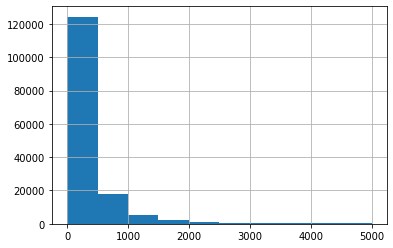

In [13]:
lens.hist();

In [14]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1) ## each colum may have the value of one ( Labled ) . 1- calc the max # if has no lable max = 0 then col = 1 -0 = 0
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
len(train),len(test)

(159571, 153164)

In [16]:
## deal with nulls 
COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

### Building the model¶


In [17]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
def clean(s): return re_tok.sub(r' \1 ', s)

In [18]:
## decide vocab size 
words = []
for t in text:
    words.extend(tokenize(t))
print(words[:100])
vocab = list(set(words))
print(len(words), len(vocab))

['Explanation', 'Why', 'the', 'edits', 'made', 'under', 'my', 'username', 'Hardcore', 'Metallica', 'Fan', 'were', 'reverted', '?', 'They', 'weren', "'", 't', 'vandalisms', ',', 'just', 'closure', 'on', 'some', 'GAs', 'after', 'I', 'voted', 'at', 'New', 'York', 'Dolls', 'FAC', '.', 'And', 'please', 'don', "'", 't', 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', 'I', "'", 'm', 'retired', 'now', '.', '89', '.', '205', '.', '38', '.', '27', 'D', "'", 'aww', '!', 'He', 'matches', 'this', 'background', 'colour', 'I', "'", 'm', 'seemingly', 'stuck', 'with', '.', 'Thanks', '.', '(', 'talk', ')', '21', ':', '51', ',', 'January', '11', ',', '2016', '(', 'UTC', ')', 'Hey', 'man', ',', 'I', "'", 'm', 'really', 'not']
13610355 234714


In [20]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [21]:
clean(train['comment_text'][0])

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted ?  They weren ' t vandalisms ,  just closure on some GAs after I voted at New York Dolls FAC .  And please don ' t remove the template from the talk page since I ' m retired now . 89 . 205 . 38 . 27"

### Test for tfidf ## Glove ## Skipgram 

In [22]:
#########################

In [47]:
def full_word_embedding(vtrain_data,vtest_data):
    # switch data back to text 
    train_labels = vtrain_data[label_cols]
    txt_train_data = [clean(txt) for txt in train['comment_text']]
    txt_test_data = [clean(txt) for txt in test['comment_text']]
    
    # integer encode the documents
    vocab_size = 10000
    ############One hot encoding #########
    encoded_txt_train_data = [keras.preprocessing.text.one_hot(d, vocab_size) for d in txt_train_data]
    encoded_txt_test_data = [keras.preprocessing.text.one_hot(d, vocab_size) for d in txt_test_data]
    ##print(encoded_txt_train_data)

    ptxt_train_data = keras.preprocessing.sequence.pad_sequences(encoded_txt_train_data,
                                                            padding='post',
                                                            maxlen=5000)

    ptxt_test_data = keras.preprocessing.sequence.pad_sequences(encoded_txt_test_data,
                                                           padding='post',
                                                           maxlen=5000)
    partial_x_train = ptxt_train_data #[:10000]
    partial_y_train = train_labels #[:10000]
    ############
    return (partial_x_train,partial_y_train,ptxt_test_data)

In [48]:
x_train,y_train,test_data = full_word_embedding(train,test)

In [49]:
x_train.shape,y_train.shape

((159571, 5000), (159571, 6))

In [50]:
max_features = 30000
maxlen = 5000
embed_size = 300
vocab_size = 10000

def get_model():
    inp = keras.layers.Input(shape=(maxlen, ))
    x = keras.layers.Embedding(vocab_size, 16)(inp)
    x = keras.layers.SpatialDropout1D(0.2)(x)    
    x = keras.layers.GRU(80, return_sequences=True)(x)
    avg_pool = keras.layers.GlobalAveragePooling1D()(x)
    max_pool = keras.layers.GlobalMaxPooling1D()(x)
    conc = keras.layers.concatenate([avg_pool, max_pool])
    outp = keras.layers.Dense(6, activation="sigmoid")(conc)
    
    model = keras.models.Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [51]:
model1 = get_model()

In [53]:
batch_size = 32
epochs = 1

X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)

hist = model1.fit(X_tra, y_tra.values, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val.values),
                  verbose=1)

Train on 151592 samples, validate on 7979 samples
Epoch 1/5
 62752/151592 [===========>..................] - ETA: 7:04 - loss: 0.0520 - accuracy: 0.9811

KeyboardInterrupt: 

In [31]:
tf.__version__

'2.0.0'

In [32]:
# serialize model to JSON
model_json = model1.to_json()
with open("hm_data/toxic_data/models/my_model1.json", "w") as json_file:
    json_file.write(model_json)
    
model1.save_weights('hm_data/toxic_data/models/my_model1_weights.h5')

In [33]:
### load the model 1 
# load json and create model
json_file = open('hm_data/toxic_data/models/my_model1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model1 = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
model1.load_weights("hm_data/toxic_data/models/my_model1_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [34]:
def column(matrix, i):
    return [row[i] for row in matrix]

In [36]:
y_pred = model1.predict(test_data, batch_size=1024)

In [39]:
submission = pd.DataFrame()
submission['id'] = test['id']
submission['toxic'] = column(y_pred, 0)
submission['severe_toxic'] = column(y_pred, 1)
submission['obscene'] = column(y_pred, 2)
submission['threat'] = column(y_pred, 3)
submission['insult'] = column(y_pred, 4)
submission['identity_hate'] = column(y_pred, 5)

In [40]:
submission.to_csv('hm_data/toxic_data/submission.csv', index=False)